# Offline LDAS example

This is following both the shell script `osm/surface_an_offline.ksh` that is then executing the python script `osm/sekf_ascat_slv_assim.py` performing the main soil moisture SEKF assimilation for the offline system. Currently the system takes satellite observations of surface soil moisture and 2D-OI'd fields of synop T2m and RH2m to update the top 3 layers of soil moisture in the model.

As discussed we can try and make this more modular and variable agnostic while adding soil temperature layer 1-3. This will involve work both at the shell script and python script level. It may also involve tweaking the specification of the prepIFS suite too. It will be a good opportunity to check for any bugs or mismatches in times etc 🙌

In [119]:
# Make some imports
import os
import sys, getopt
import numpy as np
from netCDF4 import Dataset
from osm import sekf_functions
from time import time

# Some notebook imports
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


def plot_model_data(data, lat, lon, cmap='viridis', s=1, ax=None, **kwargs):
    """
    Create a scatter plot of data points on a map with country outlines.
    
    Args:
        data (array-like): 1D array of values to plot
        lat (array-like): Latitude coordinates
        lon (array-like): Longitude coordinates
        
    Returns:
        fig, ax: The figure and axis objects
    """
    # Create figure and axis with a specific map projection
    if ax is None:
        fig = plt.figure(figsize=(6, 4))
        ax = plt.axes(projection=ccrs.Robinson())
        ret_val = fig, ax
    else:
        fig = ax.figure
        ret_val = ax
    
    ax.coastlines()
    # Create scatter plot
    scatter = ax.scatter(lon, lat, 
                        c=data,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap,
                        s=s,  # Point size
                        alpha=0.5,  # Transparency
                        **kwargs)
    plt.colorbar(scatter, ax=ax, orientation='horizontal', 
                label='Value', pad=0.05)
    ax.set_global()
    return ret_val

In [61]:
# Nonsense cell
# How the shell script is executed:
# compute_SEKF_Jacobians.py -t 00 -e 06 -r $RUNDIR -p ${PASTDIR} -j $LUSE_EDA_JACOB -i $initime -f ${FREQ_PP_OSM}
# sekf_ascat_slv_assim.py -t 00 -e 06 -s $LSAVE_SEKF -a $LUSE_ASCAT -j $LUSE_EDA_JACOB -f ${FREQ_PP_OSM}
# compute_SEKF_Jacobians.py -t 00 -e 06 -r ./ -p ./ -j true -i false -f 1
# sekf_ascat_slv_assim.py -t 00 -e 06 -s false -a true -j true -f 1
# compute_SEKF_Jacobians.py -t 12 -e 18 -r /ec/fws5/sb/work/rd/daep/hzg1/data/osm/outdata/20171107/lw12/an_dir -p /ec/fws5/sb/work/rd/daep/hzg1/data/osm/outdata/20171107/lw12/an_dir/../../lw00 -j true -i false -f 1
# sekf_ascat_slv_assim.py -t 12 -e 18 -s true -a true -j true -f 1

# sekf_snow_assim.py -t 00 -e 06 -s true -m true -n 5 -f 1 -b 0.5
# sekf_snow_assim.py -t 12 -e 18 -s true -m true -n 5 -f 1 -b 0.5

### Consider the following for selecting variables from LSM nc files ###
# Will extract the variables as float32 instead of float64, save space and possibly time in SEKF steps #
# cdo -b 32 -f nc select,name=SoilMoist,SWE,snowdens,SWEML,snowdensML restartout.nc test_cdo.nc


# Set some flags that would have been passed from command line in `.ksh` script

In [62]:
Time00 = "00"
Time06 = "06"
LSAVE_SEKF = "false"
LUSE_ASCAT = "true"
LUSE_EDA_JACOB = "false"
freq = 1

nsteps=int(12.0/freq)
s_freq=int(1.0/freq)
Times = [Time00, Time06]

# Reading in all model the background values

This can be updated to be more general, there may be unecessary declared variables here

In [117]:
%%time
oper_config = True

#    Read in model from netCDF files
#    --------------------------------------------------------
SLV_assim = True

Control_vars = ["swvl1", "swvl2", "swvl3"]
Obs = ["ssm", "T2m", "RH2m"]
Model = dict()
Data = dict()

# BASE_DIR = "/ec/res4/scratch/daep/offline_hres_surf_ana/"
BASE_DIR = "data/outdata/20240701/lw00/"

# open soil moisture at restart time (4-layers from the restartout.nc file)
Model["SM_control_f"] = Dataset(f"{BASE_DIR}/SoilMoist_control_test.nc", "r+") 
Model["SM_control"] = Model["SM_control_f"].variables["SoilMoist"]  # shape: (layer, space)

# SEKF save file, contains diagnostics of the SEKF assimilation
if LSAVE_SEKF == "true":
    Model["SEKF_save_f"] = Dataset("SEKF_save.nc", "r+")
    print(Model["SEKF_save_f"])
    Model["SEKF_save"] = Model["SEKF_save_f"].variables["T2m"]

# open soil moisture at forecast time (4-layers from the ssm_forecast.nc file)
Model["SM_background_f"] = Dataset(f"{BASE_DIR}/ssm_forecast.nc", "r")
Model["SM_background"] = Model["SM_background_f"].variables["SoilMoist"][0:nsteps:s_freq]  # shape: (time, layer, space)
Model["SM_background_f"].close()

# for screen-level variables, if SLV_assim (if applicable):
Model["T2m_background_f"] = Dataset(f"{BASE_DIR}/T2m_forecast.nc", "r")
Model["T2m_background"] = Model["T2m_background_f"].variables["T2m"][(s_freq-1):nsteps+1:s_freq]
Model["T2m_background_f"].close()

Model["RH2m_background_f"] = Dataset(f"{BASE_DIR}/RH2m_forecast.nc", "r")
lat_vals = Model["RH2m_background_f"]["lat"][:]
lon_vals = Model["RH2m_background_f"]["lon"][:]
Model["RH2m_background"] = Model["RH2m_background_f"].variables["RH2m"][(s_freq-1):nsteps+1:s_freq]
Model["RH2m_background_f"].close()

Model["T2m_prev_f"] = Dataset(f"{BASE_DIR}/T2m_prev.nc", "r")
Model["T2m_prev"] = Model["T2m_prev_f"].variables["T2m"][(s_freq-1):nsteps+1:s_freq]
Model["T2m_prev_f"].close()

Model["RH2m_prev_f"] = Dataset(f"{BASE_DIR}/RH2m_prev.nc", "r")
Model["RH2m_prev"] = Model["RH2m_prev_f"].variables["RH2m"][(s_freq-1):nsteps+1:s_freq]
Model["RH2m_prev_f"].close()

# Set T2m and RH2m to start from T+0
Model["T2m_background"][1:, :] = Model["T2m_background"][:-1, :]
Model["RH2m_background"][1:, :] = Model["RH2m_background"][:-1, :]
Model["T2m_background"][0, :] = Model["T2m_prev"][-1, :]
Model["RH2m_background"][0, :] = Model["RH2m_prev"][-1, :]

# open data needed for ASCAT assimilation
if LUSE_ASCAT == "true":
    Model["AWC_f"] = Dataset(f"{BASE_DIR}/an_dir/AWC.nc", "r")
    Model["AWC"] = Model["AWC_f"].variables["AWC"][0]
    Model["AWC_f"].close()

Model["swe_f"] = Dataset(f"{BASE_DIR}/an_dir/swe.nc", "r")
Model["swe"] = Model["swe_f"].variables["SWE"][0]
Model["swe_f"].close()

CPU times: user 35.3 ms, sys: 59.6 ms, total: 94.9 ms
Wall time: 318 ms


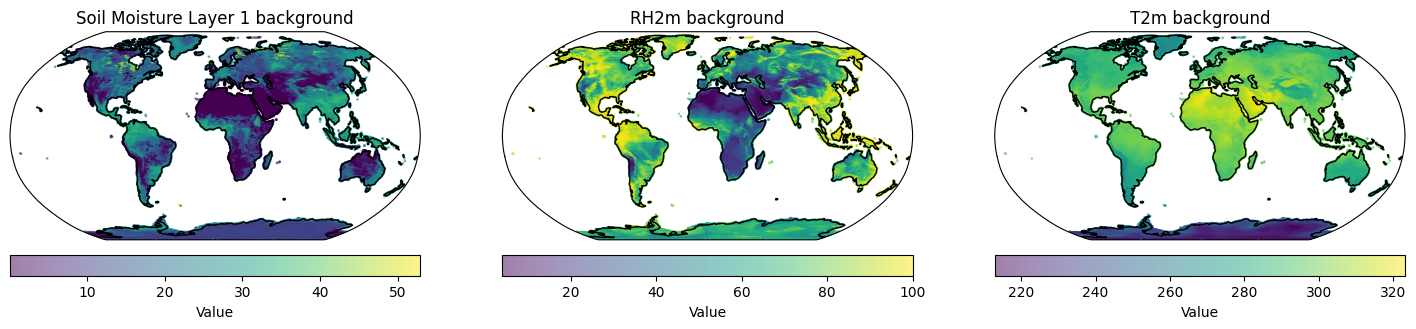

In [118]:
# Plot the background fields
fig, ax = plt.subplots(ncols=3, figsize=(18, 4), subplot_kw={"projection": ccrs.Robinson()})

plot_model_data(Model["SM_control"][0, :], lat_vals, lon_vals, cmap='viridis', ax=ax[0])
ax[0].set_title("Soil Moisture Layer 1 background")

plot_model_data(Model["RH2m_background"][0], lat_vals, lon_vals, cmap='viridis', ax=ax[1])
ax[1].set_title("RH2m background")

plot_model_data(Model["T2m_background"][0], lat_vals, lon_vals, cmap='viridis', ax=ax[2])
ax[2].set_title("T2m background")

plt.show()


# Reading in Observations for assimilation 🛰

In [66]:
for tt in Times:

    if LUSE_ASCAT == "true":
        Data["Asc" + tt + "_f"] = Dataset(f"{BASE_DIR}/control/Ascat" + tt + ".nc", "r")
        Data["Asc" + tt] = Data["Asc" + tt + "_f"].variables["Ascat" + tt][0]
        Data["Asc" + tt + "NN_f"] = Dataset(f"{BASE_DIR}/control/N_Ascat" + tt + ".nc", "r")
        Data["Asc" + tt + "NN"] = Data["Asc" + tt + "NN_f"].variables[
            "N_Ascat" + tt
        ][0]
        Data["Asc" + tt + "HH_f"] = Dataset(f"{BASE_DIR}/control/H_Ascat" + tt + ".nc", "r")
        Data["Asc" + tt + "HH"] = Data["Asc" + tt + "HH_f"].variables[
            "H_Ascat" + tt
        ][0]

        Data["Asc" + tt + "_f"].close()
        Data["Asc" + tt + "NN_f"].close()
        Data["Asc" + tt + "HH_f"].close()

    #     if SLV_assim:
    Data["T2m" + tt + "_f"] = Dataset(f"{BASE_DIR}/control/T2m" + tt + ".nc", "r")
    Data["T2m" + tt] = Data["T2m" + tt + "_f"].variables["T2m" + tt][:].flatten()
    Data["RH2m" + tt + "_f"] = Dataset(f"{BASE_DIR}/control/RH2m" + tt + ".nc", "r")
    Data["RH2m" + tt] = Data["RH2m" + tt + "_f"].variables["RH2m" + tt][:].flatten()

    #      if SLV_assim:
    Data["T2m" + tt + "_f"].close()
    Data["RH2m" + tt + "_f"].close()

# Plot the obs at T+6hrs

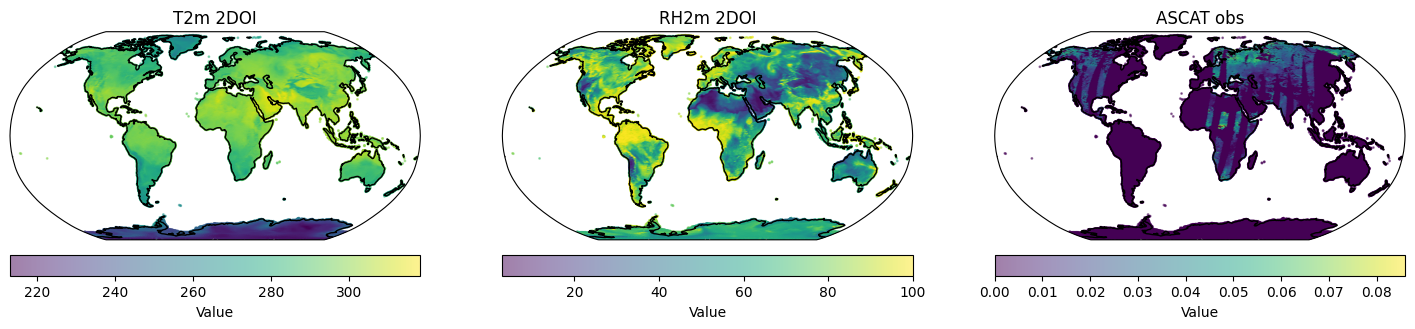

In [100]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4), subplot_kw={"projection": ccrs.Robinson()})

plot_model_data(Data["T2m" + Time06][:], lat_vals, lon_vals, cmap='viridis', ax=ax[0])
ax[0].set_title("T2m 2DOI")

plot_model_data(Data["RH2m" + Time06][:], lat_vals, lon_vals, cmap='viridis', ax=ax[1])
ax[1].set_title("RH2m 2DOI")

plot_model_data(Data["Asc" + Time06 + "NN"][:], lat_vals, lon_vals, cmap='viridis', ax=ax[2])
ax[2].set_title("ASCAT obs")

plt.show()


# Plot the obs at T+0hrs

Is something wrong with ASCAT?

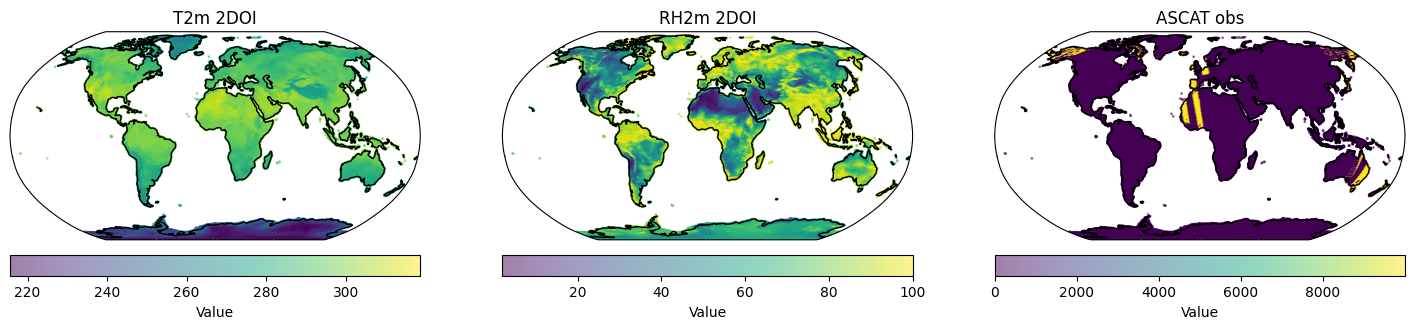

In [101]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4), subplot_kw={"projection": ccrs.Robinson()})

plot_model_data(Data["T2m" + Time00][:], lat_vals, lon_vals, cmap='viridis', ax=ax[0])
ax[0].set_title("T2m 2DOI")

plot_model_data(Data["RH2m" + Time00][:], lat_vals, lon_vals, cmap='viridis', ax=ax[1])
ax[1].set_title("RH2m 2DOI")

plot_model_data(Data["Asc" + Time00 + "NN"][:], lat_vals, lon_vals, cmap='viridis', ax=ax[2])
ax[2].set_title("ASCAT obs")

plt.show()


# Specift model in obs space and obs vector Y

In [69]:
Bqc = 0.1  # Reject ASCAT SM departures exceeding 0.1 m3/m3
# Model["SEKF_save"][:] = 0.0

# Increment calculation
# -----------------------------------------------------------------------------------------------------------------

# Model values in observation space
hx = np.array(
    [
        [Model["T2m_background"][:, :]],
        [Model["RH2m_background"][:, :]],
        [Model["SM_background"][:, 0, :] / 70.0],
    ],
    dtype="float32",
)

# Observations themselves

if LUSE_ASCAT == "true":
    Y00 = np.array(
        [
            [Data["T2m" + Times[0]]],
            [Data["RH2m" + Times[0]]],
            [Data["Asc" + Times[0]]],
        ],
        dtype="float32",
    )
    Y06 = np.array(
        [
            [Data["T2m" + Times[1]]],
            [Data["RH2m" + Times[1]]],
            [Data["Asc" + Times[1]]],
        ],
        dtype="float32",
    )
else:
    Y00 = np.array(
        [
            [Data["T2m" + Times[0]]],
            [Data["RH2m" + Times[0]]],
            [Data["RH2m" + Times[0]] * 0.0],
        ],
        dtype="float32",
    )
    Y06 = np.array(
        [
            [Data["T2m" + Times[1]]],
            [Data["RH2m" + Times[1]]],
            [Data["RH2m" + Times[1]] * 0.0],
        ],
        dtype="float32",
    )

In [70]:
print(hx.shape)
print(hx[2,0,0,:])
print(Y00)

(3, 1, 12, 120459)
[0.24507545 0.2871149  0.3621424  ... 0.15118961 0.13480163 0.13495426]
[[[274.18124  273.07974  270.7025   ... 221.09967  221.15402  221.20442 ]]

 [[ 91.87573   91.92519   97.39816  ...  57.008663  56.841408  56.62044 ]]

 [[  0.         0.         0.       ...   0.         0.         0.      ]]]


# Specify the background and observation error covariance matrices

In [71]:
#    Background and observations errors
#    --------------------------------------------------------

#   As in ECMWF operations,
B_ERR = 0.02

Bmat = np.array(
    [[B_ERR ** 2, 0.0, 0.0], [0.0, B_ERR ** 2, 0.0], [0.0, 0.0, B_ERR ** 2]],
    dtype="float32",
)

# Test a depth varying clim-B derived from EDA SM spread but using B_ERR
# Bmat = (B_ERR**2 * np.diag([1., 0.7, 0.6])).astype("float32")

# Ascat observation errors
R_ERR_asc00 = 0.0025
R_ERR_asc06 = R_ERR_asc00

# T2m/RH2m Observation errors
R_ERR_T2m = 1.0
R_ERR_RH2m = 16.0

# Observation-error covariance matrix (diagonal)
Rmat = np.array(
    [
        [R_ERR_T2m, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, R_ERR_RH2m, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, R_ERR_asc00, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, R_ERR_T2m, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, R_ERR_RH2m, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, R_ERR_asc06],
    ],
    dtype="float32",
)

#    Observation operator Jacobians
#    --------------------------------------------------------
Hmat = np.load(f"{BASE_DIR}/an_dir/HMAT.npy")
Htmat = Hmat.transpose()  # Hmat.transpose()
Hmat.shape

(6, 3, 120459)

# Screen observations with different thresholds
Will need to make this more general if we are adding many new variables. One function is dealing with thinning the EDA derived H matrix Jacobian and one is using the finitie-difference Jacobians under the `else` statement. Using finite-differences most of the checks on `Hmat` pass so are maybe not necessary?

In [72]:
#    Screening and increment calculation
# -----------------------------------------------------------------------------------------------------------------   

if LUSE_EDA_JACOB == "true":

    var_swvl1_time00 = Dataset(f"var_{Time00}_swvl1.nc", "r")[f"var_{Time00}_swvl1"][0]
    var_swvl1_time06 = Dataset(f"var_{Time06}_swvl1.nc", "r")[f"var_{Time06}_swvl1"][0]
    var_swvl2_time00 = Dataset(f"var_{Time00}_swvl2.nc", "r")[f"var_{Time00}_swvl2"][0]
    var_swvl2_time06 = Dataset(f"var_{Time06}_swvl2.nc", "r")[f"var_{Time06}_swvl2"][0]
    var_swvl3_time00=np.load("variance_swvl3_"+Time00+".npy")
    var_swvl3_time06=np.load("variance_swvl3_"+Time06+".npy")

    p_screen = np.where(
        (Y00[0, 0, :] > 274.0)
        & (Y06[0, 0, :] > 274.0)
        & (Model["swe"][:] < 0.01)
        & (Model["SM_background"][0, 0, :] > 0.0)
        & (abs(Hmat[2, 0, :]) < 2.0)
        & (abs(Hmat[2, 1, :]) < 2.0)
        & (abs(Hmat[2, 2, :]) < 2.0)
        & (abs(Hmat[0, 0, :]) < 50.0)
        & (abs(Hmat[0, 1, :]) < 50.0)
        & (abs(Hmat[0, 2, :]) < 50.0)
        & (abs(Hmat[1, 0, :]) < 500.0)
        & (abs(Hmat[1, 1, :]) < 500.0)
        & (abs(Hmat[1, 2, :]) < 500.0)
        & (abs(Hmat[5, 0, :]) < 2.0)
        & (abs(Hmat[5, 1, :]) < 2.0)
        & (abs(Hmat[5, 2, :]) < 2.0)
        & (abs(Hmat[3, 0, :]) < 50.0)
        & (abs(Hmat[3, 1, :]) < 50.0)
        & (abs(Hmat[3, 2, :]) < 50.0)
        & (abs(Hmat[4, 0, :]) < 500.0)
        & (abs(Hmat[4, 1, :]) < 500.0)
        & (abs(Hmat[4, 2, :]) < 500.0)
        & (var_swvl1_time00 > VAR_TOL)
        & (var_swvl1_time06 > VAR_TOL)
        & (var_swvl2_time00 > VAR_TOL)
        & (var_swvl2_time06 > VAR_TOL)
        & (var_swvl3_time00 > VAR_TOL)
        & (var_swvl3_time06 > VAR_TOL)
    )[0]
else:
    p_screen = np.where(
        (Y00[0, 0, :] > 274.0)
        & (Y06[0, 0, :] > 274.0)
        & (Model["swe"][:] < 0.01)
        & (Model["SM_background"][0, 0, :] > 0.0)
        & (abs(Hmat[2, 0, :]) < 2.0)
        & (abs(Hmat[2, 1, :]) < 2.0)
        & (abs(Hmat[2, 2, :]) < 2.0)
        & (abs(Hmat[0, 0, :]) < 50.0)
        & (abs(Hmat[0, 1, :]) < 50.0)
        & (abs(Hmat[0, 2, :]) < 50.0)
        & (abs(Hmat[1, 0, :]) < 500.0)
        & (abs(Hmat[1, 1, :]) < 500.0)
        & (abs(Hmat[1, 2, :]) < 500.0)
        & (abs(Hmat[5, 0, :]) < 2.0)
        & (abs(Hmat[5, 1, :]) < 2.0)
        & (abs(Hmat[5, 2, :]) < 2.0)
        & (abs(Hmat[3, 0, :]) < 50.0)
        & (abs(Hmat[3, 1, :]) < 50.0)
        & (abs(Hmat[3, 2, :]) < 50.0)
        & (abs(Hmat[4, 0, :]) < 500.0)
        & (abs(Hmat[4, 1, :]) < 500.0)
        & (abs(Hmat[4, 2, :]) < 500.0)
    )[0]

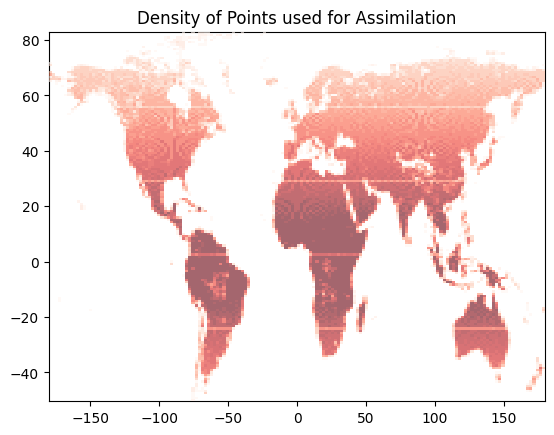

In [95]:
# Plot the density of points used for assimilation
plt.hist2d((lon_vals[p_screen] + 180) % 360 - 180, lat_vals[p_screen], bins=160, zorder=10, alpha=0.6, cmin=1, cmap="Reds", vmax=20)  # norm=LogNorm())
plt.title("Density of Points used for Assimilation")
plt.show()

# Generate innovations of $(y-hx)$

In [73]:
#    Setup matrices for points
# -----------------------------------------------------------------------------------------------------------------

innov_mat = dict()

innov_mat[Time00] = np.array(Y00[:, 0, p_screen] - hx[:, 0, 0, p_screen]) * 0.0
innov_mat[Time06] = np.array(Y06[:, 0, p_screen] - hx[:, 0, 6, p_screen]) * 0.0

p_slv = dict()
if SLV_assim:

    # Points where SLV passes quality control:
    p_slv[Time00] = np.where(
        (abs(Y00[0, 0, p_screen] - hx[0, 0, 0, p_screen]) < 5.0)
        & (abs(Y00[1, 0, p_screen] - hx[1, 0, 0, p_screen]) < 20.0)
    )[0]
    innov_mat[Time00][0:2, p_slv[Time00]] = np.array(
        Y00[0:2, 0, p_screen[p_slv[Time00]]]
        - hx[0:2, 0, 0, p_screen[p_slv[Time00]]]
    )

    p_slv[Time06] = np.where(
        (abs(Y06[0, 0, p_screen] - hx[0, 0, 6, p_screen]) < 5.0)
        & (abs(Y06[1, 0, p_screen] - hx[1, 0, 6, p_screen]) < 20.0)
    )[0]
    innov_mat[Time06][0:2, p_slv[Time06]] = np.array(
        Y06[0:2, 0, p_screen[p_slv[Time06]]]
        - hx[0:2, 0, 6, p_screen[p_slv[Time06]]]
    )

p_ascat = dict()
if LUSE_ASCAT == "true":

    # Points where ascat passes quality control:
    Bqc = 0.1
    p_ascat[Time00] = np.where(
        (abs(Y00[2, 0, p_screen] - hx[2, 0, 0, p_screen]) < Bqc)
    )[0]
    innov_mat[Time00][2, p_ascat[Time00]] = np.array(
        Y00[2, 0, p_screen[p_ascat[Time00]]]
        - hx[2, 0, 0, p_screen[p_ascat[Time00]]]
    )

    p_ascat[Time06] = np.where(
        (abs(Y06[2, 0, p_screen] - hx[2, 0, 6, p_screen]) < Bqc)
    )[0]
    innov_mat[Time06][2, p_ascat[Time06]] = np.array(
        Y06[2, 0, p_screen[p_ascat[Time06]]]
        - hx[2, 0, 6, p_screen[p_ascat[Time06]]]
    )

innov_all = np.concatenate((innov_mat[Time00], innov_mat[Time06]), axis=0)

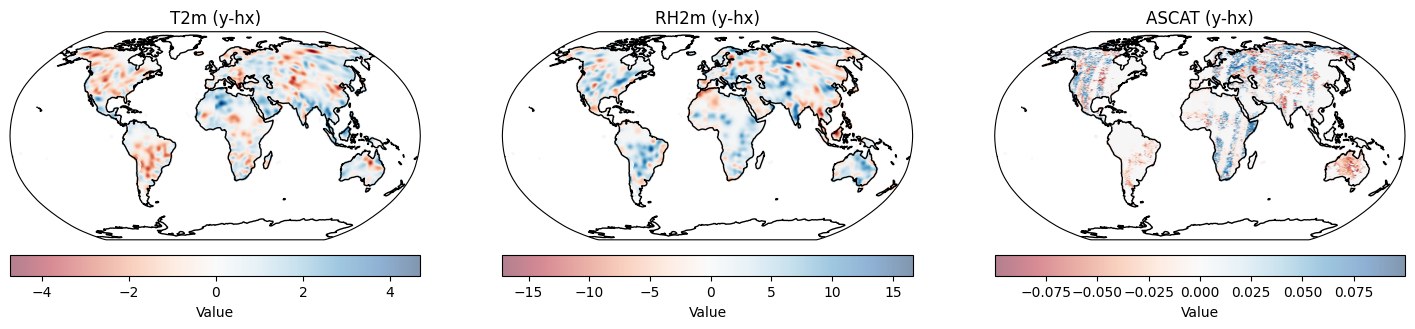

In [115]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4), subplot_kw={"projection": ccrs.Robinson()})

plot_model_data(innov_mat[Time06][0,:], lat_vals[p_screen], lon_vals[p_screen], cmap='RdBu', ax=ax[0])
ax[0].set_title("T2m (y-hx)")

plot_model_data(innov_mat[Time06][1,:], lat_vals[p_screen], lon_vals[p_screen], cmap='RdBu', ax=ax[1])
ax[1].set_title("RH2m (y-hx)")

plot_model_data(innov_mat[Time06][2,:], lat_vals[p_screen], lon_vals[p_screen], cmap='RdBu', ax=ax[2])
ax[2].set_title("ASCAT (y-hx)")

plt.show()

# Run the actual DA!
Using the Kalman gain specification under the `osm/sekf_functions.py` file

In [74]:
bias_innov=None
INC, K_gain = sekf_functions.Inc_calc_ecmwf(  # Nice vectorised implementation of the SEKF with np.einsum!
                                            p_screen,
                                            Bmat[:, :],
                                            Hmat[:, :, p_screen],
                                            Htmat[p_screen, :, :],
                                            Rmat[:, :],
                                            innov_all,
                                            )

print("Increments min max average (layers 1-3):")
print(min(INC[:, 0]), max(INC[:, 0]), np.mean(abs(INC[:, 0])))
print(min(INC[:, 1]), max(INC[:, 1]), np.mean(abs(INC[:, 1])))
print(min(INC[:, 2]), max(INC[:, 2]), np.mean(abs(INC[:, 2])))

# Save increments to full global array before writing out:
increments = Model["SM_control"][:] * 0.0
increments[0, p_screen] = INC[:, 0]
increments[1, p_screen] = INC[:, 1]
increments[2, p_screen] = INC[:, 2]

Increments min max average (layers 1-3):
-0.06147955915600224 0.06099834093595069 0.0026219173083881814
-0.05430666564173085 0.05622166969530383 0.0010525484811436336
-0.05812233576146598 0.05690046081745968 0.000829952343335088


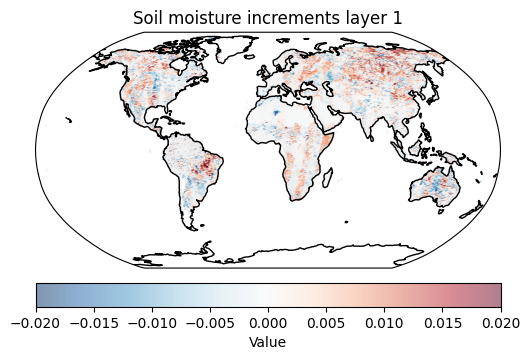

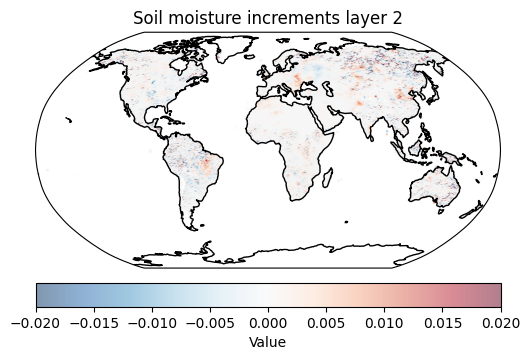

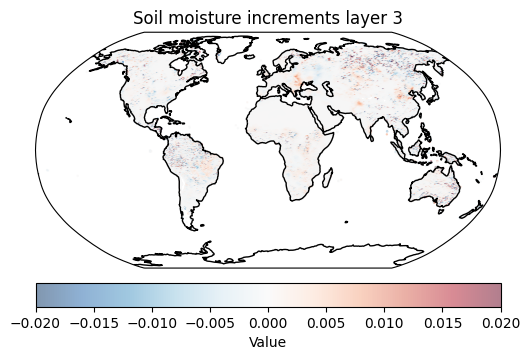

In [75]:
# plot the soil moisture increments
plot_model_data(INC[:, 0], lat_vals[p_screen], lon_vals[p_screen], cmap='RdBu_r', vmin=-0.02, vmax=0.02, s=0.5)
plt.title("Soil moisture increments layer 1")
plt.show()

plot_model_data(INC[:, 1], lat_vals[p_screen], lon_vals[p_screen], cmap='RdBu_r', vmin=-0.02, vmax=0.02, s=0.5)
plt.title("Soil moisture increments layer 2")
plt.show()

plot_model_data(INC[:, 2], lat_vals[p_screen], lon_vals[p_screen], cmap='RdBu_r', vmin=-0.02, vmax=0.02, s=0.5)
plt.title("Soil moisture increments layer 3")
plt.show()

# Increments added to final state for initialising next window
Here we add the increments and also add some checks around soil moisture being above the wilting/residual point

In [76]:
#  Soil moisture increment added to control variable final timestep for initializing following assimilation window
if (LUSE_ASCAT == "true"):

    innov_mat[Time00+'_an_depar'] = np.array(Y00[2, 0, p_screen] - hx[2, 0, 0, p_screen]) * 0.0
    innov_mat[Time06+'_an_depar'] = np.array(Y06[2, 0, p_screen] - hx[2, 0, 6, p_screen]) * 0.0

    innov_mat[Time00+'_an_depar'][p_ascat[Time00]] = innov_mat[Time00][2, p_ascat[Time00]] - increments[0,p_screen[p_ascat[Time00]]]
    innov_mat[Time06+'_an_depar'][p_ascat[Time06]] = innov_mat[Time06][2, p_ascat[Time06]] - increments[0,p_screen[p_ascat[Time06]]]

# Define wilting point array for screening 
soil_type_arr = Dataset(f"{BASE_DIR}/an_dir/surfclim", "r").variables["sotype"][:]
# lookup wilting point from soil type
soil_dic = {0: np.nan,
            1: 0.059,
            2: 0.151,
            3: 0.133,
            4: 0.279,
            5: 0.335,
            6: 0.267,
            7: 0.151}
zwilt_arr = np.array([soil_dic[x] for x in soil_type_arr[:]])
# Find indices of swvl2/3 < z_wilt
swvl2_idx  = np.where(Model["SM_background"][0, 1, :] < zwilt_arr)[0]
swvl3_idx  = np.where(Model["SM_background"][0, 2, :] < zwilt_arr)[0]
# Turn off SLV assimilation where swvl2/3 < z_wilt by setting increment elements to zero
increments[1, swvl2_idx] = 0
increments[2, swvl3_idx] = 0

increments[0, :] = increments[0, :] * 70.0
increments[1, :] = increments[1, :] * 210.0
increments[2, :] = increments[2, :] * 720.0

for x in range(3):
    Model["SM_control"][x, :] = Model["SM_control"][x, :] + increments[x, :]

SM1 = np.array(Model["SM_control"][0, :])
SM2 = np.array(Model["SM_control"][1, :])
SM3 = np.array(Model["SM_control"][2, :])

#  Ensure soil moisture is higher than residual value and lower than saturated value
SM1 = [
    0.01 if x < 0.01 else (0.7660 * 70.0) if x > (0.7660 * 70.0) else x for x in SM1
]
SM2 = [
    0.01 if x < 0.01 else (0.7660 * 210.0) if x > (0.7660 * 210.0) else x
    for x in SM2
]
SM3 = [
    0.01 if x < 0.01 else (0.7660 * 720.0) if x > (0.7660 * 720.0) else x
    for x in SM3
]

Model["SM_control"][0, :] = SM1
Model["SM_control"][1, :] = SM2
Model["SM_control"][2, :] = SM3

In [79]:
sekf_functions.summarise(
    lat_vals,
    lon_vals,
    p_screen,
    p_slv,
    p_ascat,
    innov_mat,
    Data,
    Times,
    LUSE_ASCAT,
    SLV_assim,
    False,
    bias_innov,
    Model
)

#  Close open files
Model["SM_control_f"].close()

######################### Summary of USED observations stats ###########################
  time  obstype             number    min lat    max lat    min lon    max lon    min obsvalue    max obsvalue      min state    max state    min depar    mean depar    max depar
------  ----------------  --------  ---------  ---------  ---------  ---------  --------------  --------------  -------------  -----------  -----------  ------------  -----------
    00  ASCAT fg_depar00     41525   -49.6019    81.6392          0    359.674         0              0.743164    0.000142857     0.744132   -0.0999875   -0.00316236     0.099971
    00  ASCAT an_depar00     41525   -49.6019    81.6392          0    359.674         0              0.743164    0.000142857     0.74834    -0.120143    -0.00354464     0.122268
    06  ASCAT fg_depar06     44405   -47.3536    81.6392          0    359.674         0              0.789062    0.000142857     0.744132   -0.0999621    0.00366452     0.099971
    06  ASCAT an